{'eval_method': '3_fold', 'model_name': 'llama3.2:3b-instruct-fp16'}
['syntax' 'semantic' 'tests']
  category  count  percentage
0      0/3    136        68.0
1      1/3     43        21.5
2      2/3     21        10.5


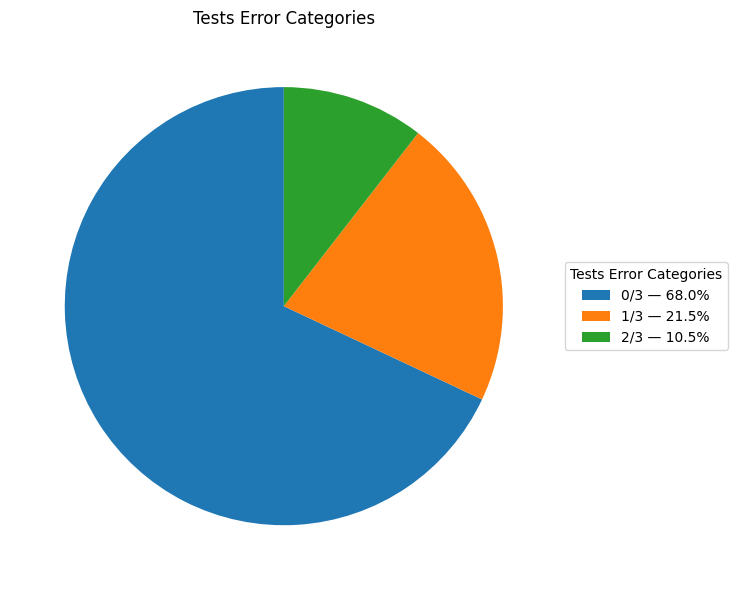

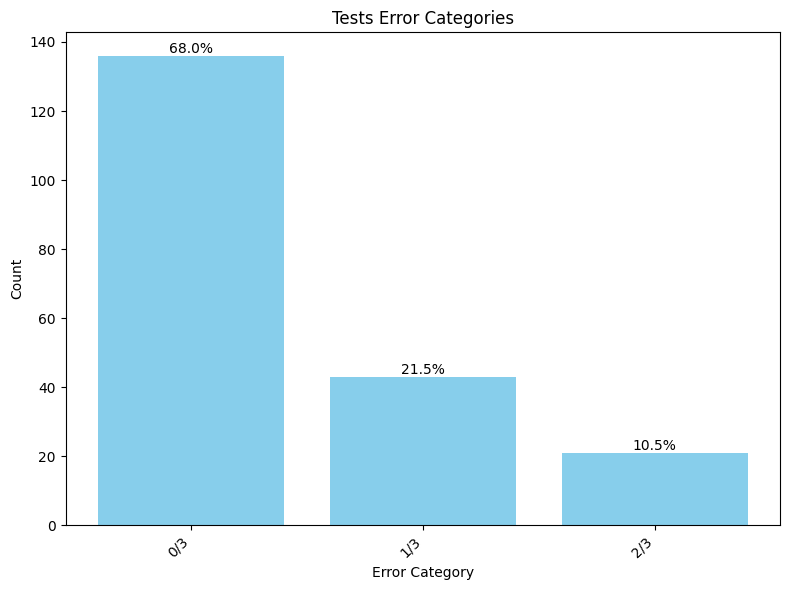

,created_at,task_id,error_type,tests_category,tests_error,test_result,stderr,stdout,code_candidate
134,2025-04-07 21:25:20.759,8,tests,1/3,"1/3 tests passed.\n Test results:\nFailed test: expected `true`, got `null`\nFailed test: expected `true`, got `null`\n","{'num_tests': 1, 'num_passed': 0, 'test_results': [{'name': 'Test check_greater', 'assertions': [{'kind': 'Passed', 'expect': 'null', 'actual': 'null'}, {'kind': 'Failed', 'expect': 'true', 'actual': 'null'}, {'kind': 'Failed', 'expect': 'true', 'actual': 'null'}], 'passed': False}]}",,"Installing dependencies for midio_example@0.1.0\n\nNo external dependencies\n\nBuilding package...\nPackage built successfully!\n\n{\n ""num_tests"": 1,\n ""num_passed"": 0,\n ""test_results"": [\n {\n ""name"": ""Test check_greater"",\n ""assertions"": [\n {\n ""kind"": ""Passed"",\n ""expect"": ""null"",\n ""actual"": ""null""\n },\n {\n ""kind"": ""Failed"",\n ""expect"": ""true"",\n ""actual"": ""null""\n },\n {\n ""kind"": ""Failed"",\n ""expect"": ""true"",\n ""actual"": ""null""\n }\n ],\n ""passed"": false\n }\n ]\n}","import(""std"", Std_k98ojb)\nimport(""http"", Http_q7o96c)\n\nmodule() main { \n func(doc: ""check whether the entered number is greater than the elements of the given array."") check_greater {\n in(x: -33, y: -26, name: ""n"") property(Number) n_a6cea7\n\n in(x: -294, y: 155, name: ""list"") property(Any) list_0b075e\n\n out(x: 546, y: 63, name: ""output"") property(Bool) output_b1d7f8\n\n instance(x: 12, y: 70) greaterthan_9c2a4d root.Std_k98ojb.Math.GreaterThan {}\n instance(x: 18, y: -23,) filter_0e3c5f root.Std_k98ojb.Iteration.Filter {}\n list_0b075e -> filter_0e3c5f.items\n n_a6cea7 -> greaterthan_9c2a4d.left\n greaterthan_9c2a4d.right -> filter_0e3c5f.value\n filter_0e3c5f.result -> output_b1d7f8\n }\n\n \n\n instance(x: -43, y: 24) check_greater_6bfc94 root.main.check_greater {}\n}\nmodule(doc: ""Contains three different tests for the 'check_greater' function node"") tests {\n instance(x: 444, y: 209) check_greater_0e0818 root.main.check_greater {}\n instance(x: -12, y: -66) test_7f8863 root.Std_k98ojb.Testing.Test {\n name: ""Test check_greater""\n }\n data_instance(x: 450, y: 343) data_7534e8 = [1, 2, 3, 4, 5]\n instance(x: 819, y: 208) check_greater_c1b8fc root.main.check_greater {}\n instance(x: 795, y: 85) asserttrue_06b1c1 root.Std_k98ojb.Testing.AssertTrue {}\n data_instance(x: 826, y: 342) data_a93579 = [2, 3, 4, 5, 6]\n instance(x: 1207, y: 209) check_greater_962a95 root.main.check_greater {}\n instance(x: 1184, y: 86) asserttrue_d04ae1 root.Std_k98ojb.Testing.AssertTrue {}\n data_instance(x: 1214, y: 344) data_a7d27f = [9, 7, 4, 8, 6, 1]\n instance(x: 416, y: 90) assertfalse_dce4a1 root.Std_k98ojb.Testing.AssertFalse {}\n data_7534e8 -> check_greater_0e0818.list_0b075e\n 4 -> check_greater_0e0818.n_a6cea7\n check_greater_c1b8fc.output_b1d7f8 -> asserttrue_06b1c1.value\n data_a93579 -> check_greater_c1b8fc.list_0b075e\n 8 -> check_greater_c1b8fc.n_a6cea7\n check_greater_962a95.output_b1d7f8 -> asserttrue_d04ae1.value\n data_a7d27f -> check_greater_962a95.list_0b075e\n 11 -> check_greater_962a95.n_a6cea7\n asserttrue_06b1c1.continue -> asserttrue_d04ae1.execute\n assertfalse_dce4a1.continue -> asserttrue_06b1c1.execute\n test_7f8863.onRun -> assertfalse_dce4a1.execute\n check_greater_0e0818.output_b1d7f8 -> assertfalse_dce4a1.value\n\n\n }"
135,2025-04-07 21:25:20.759,8,tests,1/3,"1/3 tests passed.\n Test results:\nFailed test: expected `true`, got `null`\nFailed test: expected `true`, got `null`\n","{'num_tests': 1, 'num_passed': 0, 'test_results': [{'name': 'Test check_greater', 'assertions': [{'kind': 'Passed', 'expect': 'null', 'actual': 'null'}, {'kind': 'Failed', 'expect': 'true', 'actual': 'null'}, {'kind': 'Failed', 'expect': 'true', 'actual': 'null'}], 'passed': False}]}",,"Installing dependencies for midio_example@0.1.0\n\nNo external dependencies\n\nBuilding package...\nPackage built successfully!\n\n{\n ""num_tests"": 1,\n ""num_passed"

In [3]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "few_shot_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_bar_chart, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

experiment_name = f"signature_similarity_5_shot"
error_type = "tests"
filter = {
    "eval_method": "3_fold",
    "model_name": "llama3.2:3b-instruct-fp16",
}
# Categorize and extract errors:
df = errors_to_df(experiment_name, filter=filter)
df["syntax_error"] = df["stderr"]
df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

df["tests_category"] = df["test_result"].apply(categorize_test_errors)
df["tests_error"] = df.apply(
    lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
    axis=1
)

filtered_df = df[
    (df["error_type"] == error_type) #&
    # (df[f"{error_type}_category"] == {'Invalid function header'})
][[
    "created_at",
    "task_id", 
    "error_type",
    f"{error_type}_category", 
    f"{error_type}_error", 
    "test_result",
    # "error_msg", 
    "stderr", 
    "stdout",
    "code_candidate"
]]


# Show all rows
pd.set_option('display.max_rows', None)     

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each cell
pd.set_option('display.max_colwidth', None)

print(df["error_type"].unique())


errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
print(errors_count_df)

make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")


filtered_df.head(10)

